# Homework 5 and 6

In [1]:
import random
import math

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
random.seed(0)
np.random.seed(0)
cv.setRNGSeed(0)

In [3]:
def read_image(path, is_grayscale=False):
    if is_grayscale:
        return cv.imread(path, cv.IMREAD_GRAYSCALE)
    else:
        return cv.imread(path, cv.IMREAD_COLOR)

In [4]:
def show_image(img):
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        assert len(img.shape) == 3 and img.shape[2] == 3
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

In [5]:
img1_no = 1
img2_no = 4

img1_path = f'homography_dataset/img{img1_no}.png'
img2_path = f'homography_dataset/img{img2_no}.png'
h_path = f'homography_dataset/H{img1_no}to{img2_no}p'

In [6]:
img1 = read_image(img1_path, is_grayscale=True)
img2 = read_image(img2_path, is_grayscale=True)

sift = cv.SIFT_create(2000)
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)

pts1 = np.array([kp1[m.queryIdx].pt for m in matches], dtype=np.float32).reshape(-1, 1, 2)
pts2 = np.array([kp2[m.trainIdx].pt for m in matches], dtype=np.float32).reshape(-1, 1, 2)

# Homework 5

In [7]:
def euclidean_distance(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

def average_corner_error(img_height: int, img_width: int, H_true: np.ndarray, H_estimated: np.ndarray) -> float:
    pts = np.array([[0, 0], [img_width, 0], [img_width, img_height], [0, img_height]], dtype=np.float32).reshape(1, 4, 2)
    pts_true = cv.perspectiveTransform(pts, H_true).reshape(4, 2)
    pts_estimated = cv.perspectiveTransform(pts, H_estimated).reshape(4, 2)
    error = 0
    for pt_true, pt_estimated in zip(pts_true, pts_estimated):
        error += euclidean_distance(*pt_true, *pt_estimated)
    return error / 4

H_true = np.loadtxt(h_path)

Error: 391.145 pixels


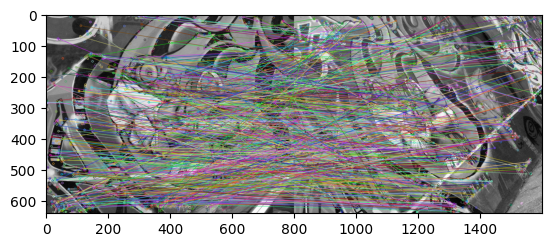

In [8]:
# Alternative 1: No outlier filtering (not recommended)

H_estimated, mask = cv.findHomography(pts1, pts2, method=0)
assert (mask == 1).all()

print('Error:', round(average_corner_error(*img1.shape, H_true, H_estimated), 3), 'pixels')
show_image(cv.drawMatches(img1, kp1, img2, kp2, matches, None))

Error: 3.242 pixels


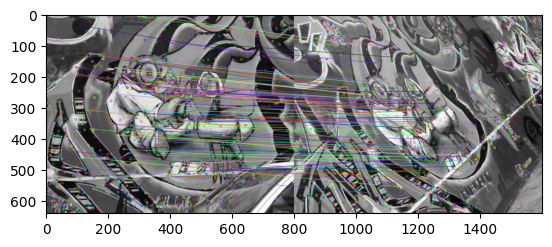

In [9]:
# Alternative 2: Outlier filtering with RANSAC (recommended)

H_estimated, mask = cv.findHomography(pts1, pts2, method=cv.RANSAC, ransacReprojThreshold=3.0)
# mask contains 1 for inliers and 0 for outliers. assert len(mask) == len(pts1) and len(mask) == len(pts2)


print('Error:', round(average_corner_error(*img1.shape, H_true, H_estimated), 3), 'pixels')
show_image(cv.drawMatches(img1, kp1, img2, kp2, matches, None, matchesMask=mask.ravel().tolist()))

Error: 10.229 pixels


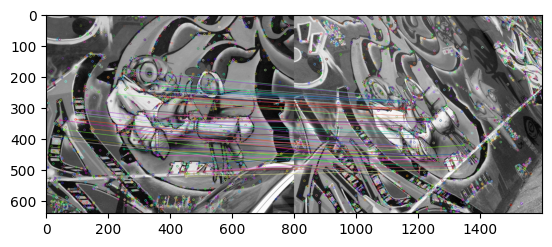

In [10]:
# Alternative 3: Our own implementation of RANSAC (using OpenCV's some functions)

def euclidean_distance(x1, y1, x2, y2):
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5


def geometric_distance(x1, y1, x2, y2, H):
    # We implement "transfer error".
    # See "Error in one image." from Multiple View Geometry in Computer Vision, 2nd Edition, page 94.
    # Euclidean distance between real (x2, y2) and estimated (x2, y2).
    estimated_x2, estimated_y2 = cv.perspectiveTransform(np.array([[[x1, y1]]], dtype=np.float32), H)[0][0]
    return euclidean_distance(x2, y2, estimated_x2, estimated_y2)


def filter_outliers(matches, kp1, kp2, threshold=3, iteration_count=1000):
    best_inlier_list = []

    for _ in range(iteration_count):
        match_sample = random.sample(matches, 4)
        src_pts = np.array([kp1[m.queryIdx].pt for m in match_sample], dtype=np.float32).reshape(-1, 1, 2)
        dst_pts = np.array([kp2[m.trainIdx].pt for m in match_sample], dtype=np.float32).reshape(-1, 1, 2)
        H = cv.getPerspectiveTransform(src_pts, dst_pts)

        # TODO: If H is None then continue

        inlier_list = []
        for match in matches:
            keypoint1 = kp1[match.queryIdx]
            keypoint2 = kp2[match.trainIdx]

            error = geometric_distance(*keypoint1.pt, *keypoint2.pt, H)
            if error < threshold:
                inlier_list.append(match)

        if len(inlier_list) > len(best_inlier_list):
            best_inlier_list = inlier_list

    return best_inlier_list


matches_inliers = filter_outliers(matches, kp1, kp2, threshold=3, iteration_count=1000)

pts1_inliers = np.array([kp1[m.queryIdx].pt for m in matches_inliers], dtype=np.float32).reshape(-1, 1, 2)
pts2_inliers = np.array([kp2[m.trainIdx].pt for m in matches_inliers], dtype=np.float32).reshape(-1, 1, 2)

H_estimated, _ = cv.findHomography(pts1_inliers, pts2_inliers, method=0)

print('Error:', round(average_corner_error(*img1.shape, H_true, H_estimated), 3), 'pixels')
show_image(cv.drawMatches(img1, kp1, img2, kp2, matches_inliers, None))


# Homework 6

In [11]:
def to_homogeneous(points):
    # Nx2 -> Nx3
    return np.concatenate([points, np.ones((points.shape[0], 1))], axis=1)


def from_homogeneous(points):
    # Nx3 -> Nx2
    return points[:, :2] / points[:, 2:]


def perspective_transform(src_points, H):
    # Bu aslinda tek bir nokta uzerine uygulanan bir fonksiyon. (geometric_distance fonksiyonunda boyle kullandik.)
    # Ama batch processing yapmak icin birden fazla nokta uzerine uygulanabilir. (average_corner_error fonksiyonunda boyle kullandik.)

    assert isinstance(src_points, np.ndarray), "src_points should be numpy array"
    assert src_points.shape[1] == 2, "src_points should be Nx2 shape"
    assert src_points.dtype == np.float32, "src_points should be float32"

    assert isinstance(H, np.ndarray), "H should be numpy array"
    assert H.shape == (3, 3), "H should be 3x3 shape"
    assert H.dtype == np.float32, "H should be float32"
    
    src_points = to_homogeneous(src_points)
    dst_points = (H @ src_points.T).T
    dst_points = from_homogeneous(dst_points)

    dst_points = dst_points.astype(np.float32)

    assert dst_points.shape[1] == 2, "dst_points should be Nx2 shape"
    assert dst_points.dtype == np.float32, "output type should be float32"

    return dst_points


pt1 = (0, 0)
pt2 = (0, 1)
pt3 = (1, 1)
pt4 = (1, 0)
pts = np.array([pt1, pt2, pt3, pt4], dtype=np.float32)

# Identity
H = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float32)  # 0 DoF

# Translation
tx = 4
ty = -2
H = np.array([[1, 0, tx], [0, 1, ty], [0, 0, 1]], dtype=np.float32)  # 2 DoF = tx, ty

# Euclidean
tx = 4
ty = -2
theta = np.pi / 4
H = np.array([[np.cos(theta), -np.sin(theta), tx], [np.sin(theta), np.cos(theta), ty], [0, 0, 1]], dtype=np.float32)  # 3 DoF = tx, ty, theta

# Similarity
tx = 4
ty = -2
theta = np.pi / 4
s = 2
H = np.array([[s * np.cos(theta), -s * np.sin(theta), tx], [s * np.sin(theta), s * np.cos(theta), ty], [0, 0, 1]], dtype=np.float32)  # 4 DoF = tx, ty, theta, s

# Affine
H = np.array([[1, 2, 3], [4, 5, 6], [0, 0, 1]], dtype=np.float32)  # Son satir [0, 0, 1] olmali. (6 DoF)

# Projective
H = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 1]], dtype=np.float32)  # H[2, 2] = 1 olur. Boyle olmak zorunda degil ama 1 yapinca expressivity azalmiyor. (8 DoF)

dst_pts = perspective_transform(pts, H)
print(dst_pts)

assert np.allclose(dst_pts, cv.perspectiveTransform(pts.reshape(1, -1, 2), H).reshape(-1, 2))


[[3.        6.       ]
 [0.5555556 1.2222222]
 [0.375     0.9375   ]
 [0.5       1.25     ]]


In [12]:
# Learn how you can solve a system of linear equations (using linear algebra).
# Maybe start with solving this simple system using matrices:
# 2x + 3y - 1 = 3
# 4x + 5y = 6
# What is x and y?
# You can use numpy.linalg.solve.

# First equation is actually 2x + 3y = 4
# Second equation is 4x + 5y = 6

# In general we use x_1, x_2, x_3, ... xn to represent the variables (instead of x, y, z, ...).
# So we have 2 x_1 + 3 x_2 = 4
# and 4 x_1 + 5 x_2 = 6.

a = np.array([[2, 3], [4, 5]])  # Left hand side of the equations
b = np.array([4, 6])  # Right hand side of the equations
x = np.linalg.solve(a, b)

print("x_1 = ", x[0])
print("x_2 = ", x[1])

assert np.allclose(np.dot(a, x), b)


def get_perspective_transform(src_points, dst_points):
    """
    Compute the perspective transform matrix P given the source and destination points.
    :param src_points: source points, shape (4, 2)
    :param dst_points: destination points, shape (4, 2)
    :return: perspective transform matrix P, shape (3, 3)
    """
    assert src_points.shape == (4, 2)
    assert dst_points.shape == (4, 2)

    src_points = to_homogeneous(src_points)  # Shape (4, 3)
    dst_points = to_homogeneous(dst_points)  # Shape (4, 3)

    """
    Tek bir src point icin dusunelim:

    new_x       H11 H12 H13       src_x
    new_y   =   H21 H22 H23   @   src_y
    new_w       H31 H32  1        1

    new_x = H11 * src_x + H12 * src_y + H13
    new_y = H21 * src_x + H22 * src_y + H23
    new_w = H31 * src_x + H32 * src_y + 1

    dst_x = new_x / new_w
    dst_y = new_y / new_w

    Yani

    dst_x = (H11 * src_x + H12 * src_y + H13) / (H31 * src_x + H32 * src_y + 1)
    dst_y = (H21 * src_x + H22 * src_y + H23) / (H31 * src_x + H32 * src_y + 1)

    Boluyu sevmeyiz, karsiya atalim:

    dst_x * (H31 * src_x + H32 * src_y + 1) = H11 * src_x + H12 * src_y + H13
    dst_y * (H31 * src_x + H32 * src_y + 1) = H21 * src_x + H22 * src_y + H23

    Acalim:

    dst_x * H31 * src_x   +   dst_x * H32 * src_y   +   dst_x     =     H11 * src_x   +   H12 * src_y   +   H13
    dst_y * H31 * src_x   +   dst_y * H32 * src_y   +   dst_y     =     H21 * src_x   +   H22 * src_y   +   H23

    Sabit terimleri saga atalim, H'lerle yani bilinmeyenlerle carpilan terimleri sola)

    dst_x * H31 * src_x   +   dst_x * H32 * src_y   -   H11 * src_x   -   H12 * src_y   -   H13       =       -dst_x
    dst_y * H31 * src_x   +   dst_y * H32 * src_y   -   H21 * src_x   -   H22 * src_y   -   H23       =       -dst_y

    Burada 

    H11, H12, H13, H21, H22, H23, H31, H32 bilinmeyenler. (Yani x1, x2, ..., x8 gibi)
    dst_x, dst_y, src_x, src_y bilinenler.

    O halde ilk denklem:
                                                                            H11
                                                                            H12
                                                                            H13
    -src_x   -src_y   -1   0   0   0   dst_x * src_x   dst_x * src_y        H21    =   -dst_x
                                                                            H22
                                                                            H23
                                                                            H31
                                                                            H32

    Ikinci denklem:

                                                                            H11
                                                                            H12
                                                                            H13
    0   0   0   -src_x   -src_y   -1   dst_y * src_x   dst_y * src_y        H21    =   -dst_y
                                                                            H22
                                                                            H23
                                                                            H31
                                                                            H32

    Bu iki denklemi birlestirelim:

                                                                                    H11
                                                                                    H12
                                                                                    H13
    -src_x   -src_y   -1   0        0        0    dst_x * src_x   dst_x * src_y     H21         -dst_x
    0        0        0    -src_x   -src_y   -1   dst_y * src_x   dst_y * src_y     H22    =    -dst_y
                                                                                    H23
                                                                                    H31
                                                                                    H32


    Yani

    a = np.array([[-src_x, -src_y, -1, 0, 0, 0, dst_x * src_x, dst_x * src_y],
                    [0, 0, 0, -src_x, -src_y, -1, dst_y * src_x, dst_y * src_y]])
    
    b = np.array([-dst_x, -dst_y])

    Tabii bunu sistemi cozemeyiz. Cunku 8 bilinmeyen var ama 2 denklemimiz var.

    E zaten bu sekilde 4 noktamizin olmasinin sebebi de bu.
    Bu sekilde 4 tane a ve 4 tane b bulup bunlari birlestiririz.
    a.shape = (8, 8) olur, b.shape = (8,) olur.
    
    """

    """
    a0 = np.array([[-src_points[0][0], -src_points[0][1], -1, 0, 0, 0, dst_points[0][0] * src_points[0][0], dst_points[0][0] * src_points[0][1]],
                    [0, 0, 0, -src_points[0][0], -src_points[0][1], -1, dst_points[0][1] * src_points[0][0], dst_points[0][1] * src_points[0][1]]])
    
    b0 = np.array([-dst_points[0][0], -dst_points[0][1]])

    a1 = np.array([[-src_points[1][0], -src_points[1][1], -1, 0, 0, 0, dst_points[1][0] * src_points[1][0], dst_points[1][0] * src_points[1][1]],
                    [0, 0, 0, -src_points[1][0], -src_points[1][1], -1, dst_points[1][1] * src_points[1][0], dst_points[1][1] * src_points[1][1]]])

    b1 = np.array([-dst_points[1][0], -dst_points[1][1]])

    a2 = np.array([[-src_points[2][0], -src_points[2][1], -1, 0, 0, 0, dst_points[2][0] * src_points[2][0], dst_points[2][0] * src_points[2][1]],
                    [0, 0, 0, -src_points[2][0], -src_points[2][1], -1, dst_points[2][1] * src_points[2][0], dst_points[2][1] * src_points[2][1]]])

    b2 = np.array([-dst_points[2][0], -dst_points[2][1]])
    
    a3 = np.array([[-src_points[3][0], -src_points[3][1], -1, 0, 0, 0, dst_points[3][0] * src_points[3][0], dst_points[3][0] * src_points[3][1]],
                    [0, 0, 0, -src_points[3][0], -src_points[3][1], -1, dst_points[3][1] * src_points[3][0], dst_points[3][1] * src_points[3][1]]])

    b3 = np.array([-dst_points[3][0], -dst_points[3][1]])
    """

    def equations_from_point_correspondence(s, d):
        # src point, dst point
        a = np.array(
            [
                [-s[0], -s[1], -1, 0, 0, 0, d[0] * s[0], d[0] * s[1]],
                [0, 0, 0, -s[0], -s[1], -1, d[1] * s[0], d[1] * s[1]],
            ]
        )
        b = np.array([-d[0], -d[1]])
        return a, b

    a0, b0 = equations_from_point_correspondence(src_points[0], dst_points[0])
    a1, b1 = equations_from_point_correspondence(src_points[1], dst_points[1])
    a2, b2 = equations_from_point_correspondence(src_points[2], dst_points[2])
    a3, b3 = equations_from_point_correspondence(src_points[3], dst_points[3])

    a = np.vstack((a0, a1, a2, a3))
    b = np.hstack((b0, b1, b2, b3))

    assert a.shape == (8, 8)
    assert b.shape == (8,)

    x = np.linalg.solve(a, b)
    # I am not exactly sure how solve exactly works but in OpenCV they use RHO (Gaussian elimination) algorithm for minimal solvers like this.

    h = np.append(x, 1)
    H = h.reshape(3, 3)
    return H


# Yukarida calistirdigimiz ornek:

src_pt1 = (0, 0)
src_pt2 = (0, 1)
src_pt3 = (1, 1)
src_pt4 = (1, 0)
src_pts = np.array([src_pt1, src_pt2, src_pt3, src_pt4], dtype=np.float32)

H = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 1]], dtype=np.float32)

dst_pts = perspective_transform(src_pts, H)

# Tersten kontrol edelim:

calculated_H = get_perspective_transform(src_pts, dst_pts)
print(calculated_H)

assert np.allclose(H, calculated_H)

# Ayni cikiyorlar.
# Ancak farkli gorunumlu ayni homografi de bulabilirdik.
# (H33 = 1 olmak yerine ||h|| = 1 olacak sekilde normalize edebilirdik.)
# Su karsilastirma daha saglikli:
# 1x1'lik bir kareyi ikisiyle de transform edelim (Bu sayilari degistirsek de onemli degil). Ne kadar farkli yerlere goturuyorlar bizi?
assert math.isclose(
    average_corner_error(1, 1, H, calculated_H), 0
)  # Tam 0 gelmeyebilir, 0'a cok cok yakin gelmeli.

# Bir de tabii OpenCV'nin getPerspectiveTransform fonksiyonuyla karsilastiralim:

opencv_H = cv.getPerspectiveTransform(
    src_pts.reshape(-1, 1, 2), dst_pts.reshape(-1, 1, 2)
)
print(opencv_H)

assert np.allclose(
    calculated_H, opencv_H
)  # False also da problem degil aslinda. (Farkli gozukup de ayni olabilirler. Ama OpenCV de H33=1 yapiyor.)
assert math.isclose(
    average_corner_error(1, 1, calculated_H, opencv_H), 0, abs_tol=0.001
)  # Bu true olmali.

x_1 =  -1.0
x_2 =  2.0
[[1.00000215 1.99999785 3.        ]
 [4.00000536 4.99999464 6.        ]
 [7.00000429 7.99999571 1.        ]]
[[1.00000215 1.99999785 3.        ]
 [4.00000536 4.99999464 6.        ]
 [7.00000429 7.99999571 1.        ]]


In [13]:
def find_homography_method_equals_zero(src_pts, dst_pts):
    # Ayni get_perspective_transform gibi.
    # Ancak o minimal solver. 4 nokta eslesmesinden 1 tane H bulunur, o da onu buluyor.
    # Ancak bizde cok daha fazla nokta eslesmesi var. Hepsi mukemmel eslesmeler olsaydi ilk 4 tanesini alip o fonksiyonu cagirirdik.
    # Ancak elimizde cok fazla nokta eslesmesi var ve hepsinde az cok hata var.
    # (Daha dogrusu az hata olmali, eger cok hata icerenler varsa yani outlierlar varsa outlier filtering calistirmamiz gerekir bundan once.
    # O da RANSAC gibi bir yontemle yapilir. Bizim implementasyonumuz filter_outliers fonksiyonu. OpenCV'de ise findHomography'ye
    # method=cv.RANSAC vb. verilerek outlier filtering + homography estimation yapilabilir.)

    assert src_pts.shape[0] == dst_pts.shape[0]  # Nokta adetleri esit olmali.
    assert src_pts.shape[0] >= 4  # En az 4 nokta olmali.
    assert src_pts.shape[1] == 2  # Noktalar 2 boyutlu olmali.
    assert dst_pts.shape[1] == 2  # Noktalar 2 boyutlu olmali.
    
    correspondence_count = src_pts.shape[0]

    def equations_from_point_correspondence(s, d):
        # src point, dst point
        a = np.array(
            [
                [-s[0], -s[1], -1, 0, 0, 0, d[0] * s[0], d[0] * s[1]],
                [0, 0, 0, -s[0], -s[1], -1, d[1] * s[0], d[1] * s[1]],
            ]
        )
        b = np.array([-d[0], -d[1]])
        return a, b

    a = np.zeros((correspondence_count * 2, 8))
    b = np.zeros((correspondence_count * 2,))
    for i, (s, d) in enumerate(zip(src_pts, dst_pts)):
        this_a, this_b = equations_from_point_correspondence(s, d)
        a[i * 2 : i * 2 + 2, :] = this_a
        b[i * 2 : i * 2 + 2] = this_b

    x, _, _, _ = np.linalg.lstsq(a, b, rcond=None)
    # I am not sure how lstsq exactly works.
    # In non-minimal solvers of OpenCV usually the covariance matrix is built and the model is found as the eigenvector corresponding to the highest eigenvalue.

    # TODO: Use the matrix inverse to solve it (Again, H33=1): https://www.cs.cmu.edu/~16385/s17/Slides/10.1_2D_Alignment__LLS.pdf
    # TODO: Use np.linalg.svd, np.linalg.qr, etc. to solve it. (lstsq is a high level function that uses methods like these internally.)
    # TODO: Use the eigenvector to solve it (||h||=1 constraint): https://youtu.be/l_qjO4cM74o


    h = np.append(x, 1)
    H = h.reshape(3, 3)
    return H
    

# Yukarida calistirdigimiz ornek:

src_pt1 = (0, 0)
src_pt2 = (0, 1)
src_pt3 = (1, 1)
src_pt4 = (1, 0)
src_pts = np.array([src_pt1, src_pt2, src_pt3, src_pt4], dtype=np.float32)

H = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 1]], dtype=np.float32)

dst_pts = perspective_transform(src_pts, H)

H_estimated = find_homography_method_equals_zero(src_pts, dst_pts)

assert np.allclose(
    H, H_estimated
)  # False also da problem degil aslinda. (Farkli gozukup de ayni olabilirler. Ama OpenCV de H33=1 yapiyor.)
assert math.isclose(
    average_corner_error(1, 1, H, H_estimated), 0
)  # Bu true olmali.


# Yani find_homography_method_equals_zero minimal solver olarak da kullanilabilir.
# Ama lazim olan 4'ten fazla nokta olma durumu:

src_pts = np.array([(random.uniform(0, 1), random.uniform(0, 1)) for _ in range(10)], dtype=np.float32)  # 10 random points

H = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 1]], dtype=np.float32)

dst_pts = perspective_transform(src_pts, H)

H_estimated = find_homography_method_equals_zero(src_pts, dst_pts)

assert np.allclose(
    H, H_estimated
)

assert math.isclose(
    average_corner_error(1, 1, H, H_estimated), 0, abs_tol=0.001
) 


# Daha da onemlisi noise oldugu zaman da dogru calisabilmeli.
# Yoksa usttekinde 10 noktanin ilk 4'unu kullansak da yeter.

dst_pts = dst_pts + np.random.normal(0, 0.001, dst_pts.shape)

H_estimated = find_homography_method_equals_zero(src_pts, dst_pts)

#assert np.allclose(
#    H, H_estimated, atol=0.01
#)

assert math.isclose(
    average_corner_error(1, 1, H, H_estimated), 0, abs_tol=0.1  # Toleransi iyice arttirdik. Cunku sadece 10 nokta var. Bazen bu bile hatali oluyor.
)


# Referans implementasyonla karsilastiralim.

opencv_H, _ = cv.findHomography(src_pts.reshape(-1, 1, 2), dst_pts.reshape(-1, 1, 2), method=0)

#assert np.allclose(
#    H, H_estimated, atol=0.01
#)

assert math.isclose(
    average_corner_error(1, 1, H_estimated, opencv_H), 0, abs_tol=0.1
)
